In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.widgets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.6 MB/s eta 0:00:00
Mounted at /content/gdrive


# From Model to Production

For this exercise we're going to use a pretrained computer vision model to look at the end-to-end process of creating a deep learning application which attempts to classify images with Alzheimer's disease based on an MRI scan. The architecture we are using is the ResNet-18 (Residual Network with 18 layers).

### First let's look at a sample MRI

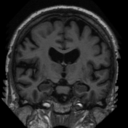

In [2]:
dest="/content/gdrive/MyDrive/FastAI/images/MRI/train/AD/OAS1_0263_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif"
im = Image.open(dest)
im.to_thumb(128,128)

We can see that the image presented to us is in the coronal plane and shows parts of the temporal and mesial-temporal lobes - areas involved in Alzheimer's disease.

### Summarise the data we have for Train/Test

In [3]:
# Look at how many images we have to train and test our deep learning method on
AD_train_entries = len(os.listdir("/content/gdrive/MyDrive/FastAI/images/MRI/train/AD/"))
AD_test_entries = len(os.listdir("/content/gdrive/MyDrive/FastAI/images/MRI/test/AD/"))
HC_train_entries = len(os.listdir("/content/gdrive/MyDrive/FastAI/images/MRI/train/HC/"))
HC_test_entries = len(os.listdir("/content/gdrive/MyDrive/FastAI/images/MRI/test/HC/"))
print(f"There are {AD_train_entries} Alzheimer's Disease and {HC_train_entries} Healthy Control images we can train our model on.")
print(f"There are {AD_test_entries} Alzheimer's Disease and {HC_test_entries} Healthy Control images we can test our model on.")

There are 481 Alzheimer's Disease and 318 Healthy Control images we can train our model on.
There are 189 Alzheimer's Disease and 147 Healthy Control images we can test our model on.


We are able to use FastAI to look over all our images to see if we have any broken data:

In [4]:
# Use get_image_files function
fns = get_image_files("/content/gdrive/MyDrive/FastAI/images/MRI/")

# Verify_images to list out any failed images
failed = verify_images(fns)
failed

(#0) []

Now that we can see we don't have any broken images, we can proceed to our next step.

Now that we have some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

## From Data to DataLoaders

`DataLoaders` is a class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model.
```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

To turn our Alzheimer's disease data into a `DataLoaders` object we need to tell fastai:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

Fastai has an extremely flexible system called the *data block API*. With this API you can fully customize every stage of the creation of your `DataLoaders`. Here is what we need to create a `DataLoaders` for the dataset that we just downloaded:

In [5]:
# Set our path and create a dataloader
path=Path("/content/gdrive/MyDrive/FastAI/images/MRI/train/")

AD = DataBlock(
    # Tuple of independent and dependent variables
    blocks=(ImageBlock, CategoryBlock),

    # Tells fastAI where to find items as file paths
    get_items=get_image_files,

    # Sets 'random' so we can recreate
    splitter=RandomSplitter(valid_pct=0.2, seed=42),

    # telling fastai what function to call to create the labels in our dataset
    get_y=parent_label,

    # Resize all of our images
    item_tfms=Resize(128))

# Create our dataloader
dls = AD.dataloaders(path)

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. When we loop through a `DataLoader` fastai will give us 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

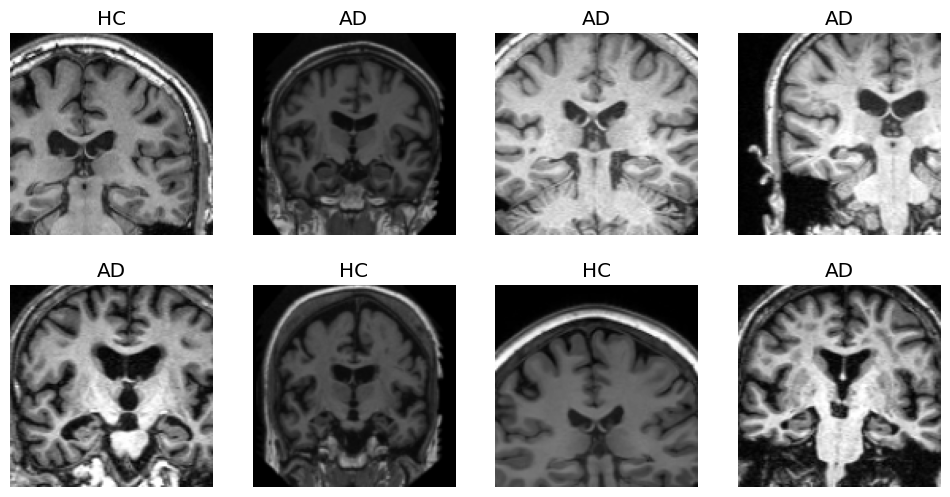

In [7]:
dls.train.show_batch(max_n=8, nrows=2)

By default `Resize` *crops* the images to fit a square shape of the size requested, using the full width or height. Other options exist in FastAI like squishing or padding.

## Training Our Model, and Use It to Clean Our Data

We'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [8]:
# ad (lowercase is our original data loaders data)
# AD (capitalized is our new transformed data loaders data)
ad = AD.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = ad.dataloaders(path)

We can now create our `Learner` and fine-tune it in the usual way:

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.068035,0.865780,0.333333,02:47


epoch,train_loss,valid_loss,error_rate,time
0,0.884425,1.167742,0.377358,03:44
1,0.792244,0.553145,0.232704,03:43
2,0.722368,0.458610,0.201258,03:50
3,0.669918,0.399303,0.157233,03:45


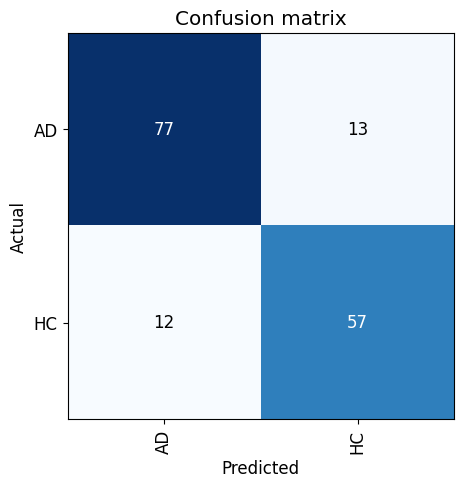

In [10]:
# We can create a confusion matrix to see where our mistakes are
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem or a model problem. To do this, we can sort our images by their *loss*.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

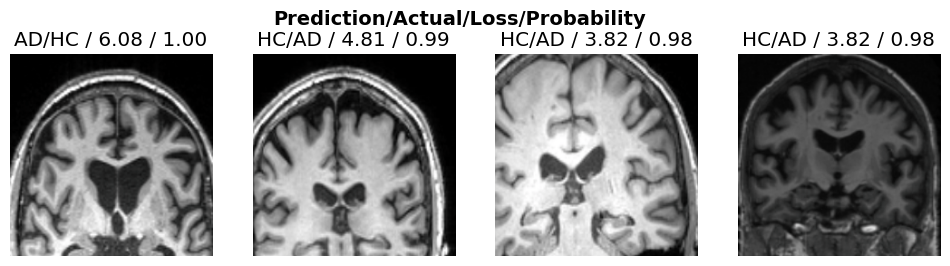

In [11]:
interp.plot_top_losses(4, nrows=1)

### Using the Model for Inference

Now we save our model *architecture* and the trained *parameters*. For this we use the `export` method, which saves the definition of how to create your `DataLoaders`. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set `DataLoader` for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call `export`, fastai will save a file called "export.pkl":

In [12]:
learn.export("/content/gdrive/MyDrive/FastAI/AD-learner.pkl")

You'll need this file wherever you deploy your app to. For now, let's try to create a simple app within our notebook.

When we use a model for getting predictions, instead of training, we call it *inference*. To create our inference learner from the exported file, we use `load_learner` (in this case, this isn't really necessary, since we already have a working `Learner` in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [13]:
learn_inf = load_learner('/content/gdrive/MyDrive/FastAI/AD-learner.pkl')

When we're doing inference, we're generally just getting predictions for one image at a time. To do this, pass a filename to `predict`:

In [18]:
learn_inf.predict('/content/gdrive/MyDrive/FastAI/images/MRI/validate_mri.png')

('AD', tensor(0), tensor([0.9972, 0.0028]))

Our learner shows us the predicted category in the format we originally provided, `['HC']`, the data format `[tensor(0)]` and the list of probabilities for each class `['[0.03, 0.97]']`

> Indented block



In [19]:
# Show us the learner categories just to be sure
category_1 = learn_inf.dls.vocab[0]
category_2 = learn_inf.dls.vocab[1]
print(f'Category 1: {category_1}; Category 2: {category_2}')

Category 1: AD; Category 2: HC
